# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

#### $x^{k+1} = \arg\underset{x\in\Delta_d}{min} [<\frac{1}{2}\gamma(A + A^T)x^k; x> + \sum\limits_{i = 1}^d x_i\ln(\frac{x_i}{x_i^k})]$
#### Перепишем в покомпонентном виде: $x^{k+1} = \arg\underset{x\in\Delta_d}{min}[\sum\limits_{i = 1}^d(\frac{1}{2}\gamma<((A + A^T)x^k)_i, x_i> + x_i\ln(\frac{x_i}{x_i^k}))]$
$\nabla_i f(x) = \frac{1}{2}\gamma ((A + A^T)x^k)_i + 1 + \ln(\frac{x_i}{x_i^k}) = 0$
#### Тогда с учетом ограничения $x$ на симплекс, получаем $x_i = \frac{x_i^k\exp(-(\frac{1}{2}\gamma((A + A^T)x^k)_i + 1))}{\sum\limits_{i = 1}^d x_i^k\exp(-(\frac{1}{2}\gamma((A + A^T)x^k)_i + 1))}$

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

In [1]:
import math
import numpy as np
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
import sklearn
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

In [2]:
d = 100
mu = 1
L = 1000
i = 0
E = np.eye(d)

def positive_determined_matrix(d, mu, L): #генерация положительно-определенной матрицы, так чтобы A-mu*I >= 0
    i = 0
    while i == 0:
        diagonal_entries = np.random.uniform(mu, L,d)
        diagonal_entries[0] = mu
        diagonal_entries[1] = L
        D = np.diag(diagonal_entries)
        m = ortho_group.rvs(d)
        A = m.dot(D).dot(np.linalg.inv(m))
        if (np.all(np.linalg.eigvals(A-mu*E) >= 0)):
            i += 1
        print(np.all(np.linalg.eigvals(A-mu*E) >= 0))
    return A

A = positive_determined_matrix(d, mu, L)
print("Проверка на положительную определенность A:", np.all(np.linalg.eigvals(A) >= 0))
print("Проверка на положительную определенность A - mu*E:", np.all(np.linalg.eigvals(A - mu*E) >= 0))

True
Проверка на положительную определенность A: True
Проверка на положительную определенность A - mu*E: True


#### Найдем $gap(x^k).$ Переформулируем задачу следующим образом: $\underset{y\in\Delta_d}{min} <Ax^k, y^k>$. Поскольку $y\in\Delta_d$, то есть $\sum\limits_{i = 1}^d y_i = 1, \forall i\in\overline{1,d} \hookrightarrow y_i\geq 0$, то решение будет достигаться на таком $y$, что $y_m = 1$, где $(Ax^k)_m = \underset{i = \overline{1, d}}{min} (Ax^k)_i, \forall i\in\overline{1, d}: i\neq m\hookrightarrow y_i = 0$.

In [3]:
def gradient(A, x):
    return A.dot(x)

def gap(A, x):
    y = np.zeros(d)
    y[np.nanargmin(gradient(A,x))] = 1
    return gradient(A,x).dot(x - y)

In [4]:
def count_x(A, learning_rate, x):
    S = 0
    for i in range (d):
        expon = -learning_rate*(A.dot(x))[i] - 1
        S = S + x[i]*np.exp(expon)
    x_final = x*np.exp(-learning_rate*(A.dot(x)) - 1)/S
    return x_final

def mirror_descent(A, start, learning_rate, amount_of_iterations):
    x = start
    begin_time = time.time()
    timeprog = []
    criterion = []
    for i in range (1, amount_of_iterations):
        x = count_x(A, learning_rate, x)
        timeprog.append(time.time() - begin_time)
        criterion.append(gap(A, x))
    return timeprog, criterion
mirror_desc = mirror_descent(A, np.ones(d)*1/100, 1/L, 10000)

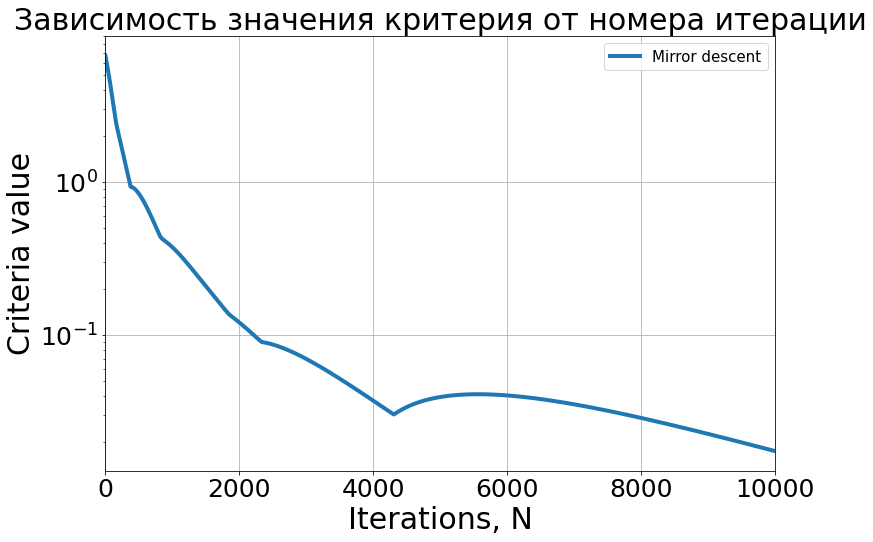

In [5]:
X1 = np.array([i for i in range(0, 9999)])
Y1 = np.array([mirror_desc[1][i] for i in range(0, 9999)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Mirror descent')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Iterations, N", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от номера итерации", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0, 10000)

plt.grid()

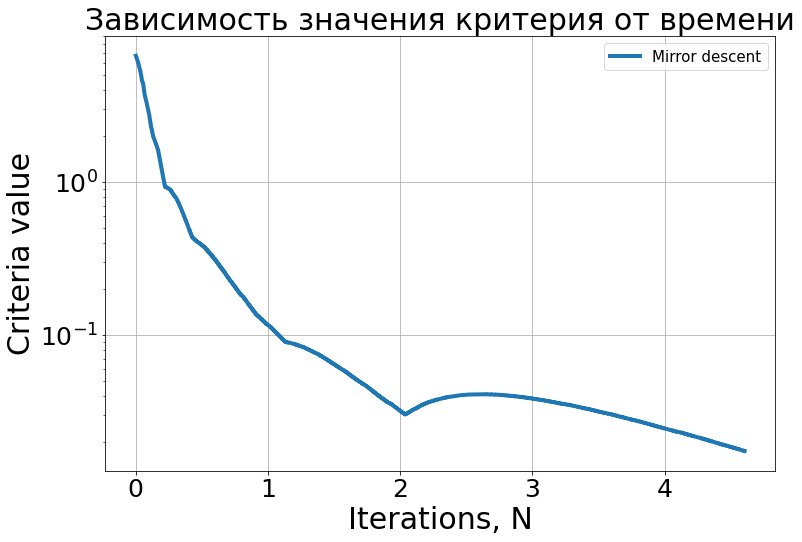

In [6]:
X1 = np.array([mirror_desc[0][i] for i in range(0, 9999)])
Y1 = np.array([mirror_desc[1][i] for i in range(0, 9999)])
  
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Mirror descent')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Iterations, N", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

#### Задача аналогичная поиску $gap$.
$s^k: s_m^k = 1$, где $(Ax^k)_m = \underset{i = \overline{1, d}}{min} (Ax^k)_i, \forall i\in\overline{1, d}: i\neq m\hookrightarrow s_i^k = 0$.

$x^{k+1} = x^k + \frac{2}{k + 2}(s^k - x^k)$.

In [7]:
def find_s(A, x):
    s = np.zeros(d)
    s[np.argmin(gradient(A,x))] = 1
    return s

def Frank_Wolfe(A, start, amount_of_iterations):
    x = start
    begin_time = time.time()
    timeprog = []
    criterion = []
    for i in range (1, amount_of_iterations):
        s = find_s(A, x)
        x = x + 2/(i+1)*(s - x)
        timeprog.append(time.time() - begin_time)
        criterion.append(gap(A, x))
    return timeprog, criterion
FW = Frank_Wolfe(A, np.ones(d)*1/100, 100000)

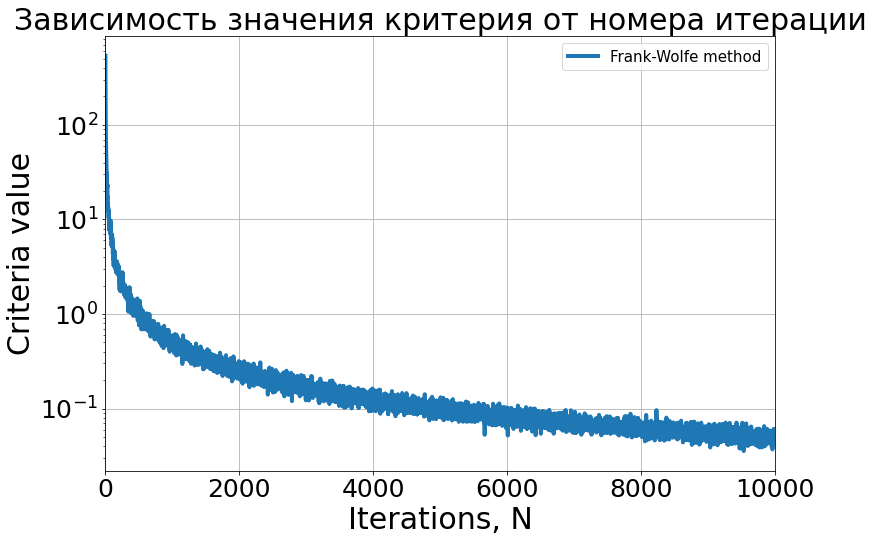

In [8]:
X1 = np.array([i for i in range(0, 9999)])
Y1 = np.array([FW[1][i] for i in range(0, 9999)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Frank-Wolfe method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Iterations, N", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от номера итерации", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0, 10000)

plt.grid()

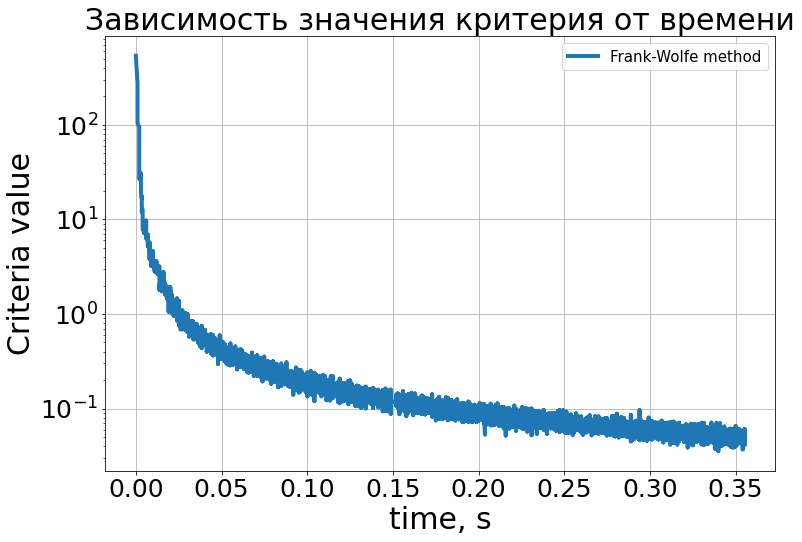

In [9]:
X1 = np.array([FW[0][i] for i in range(0, 9999)])
Y1 = np.array([FW[1][i] for i in range(0, 9999)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Frank-Wolfe method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()

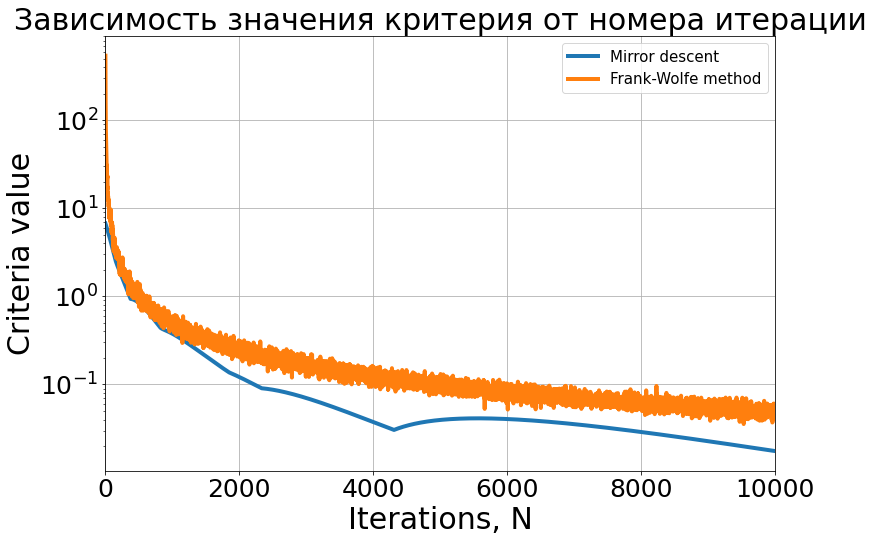

In [10]:
X1 = np.array([i for i in range(0, 9999)])
Y1 = np.array([mirror_desc[1][i] for i in range(0, 9999)])

X2 = np.array([i for i in range(0, 9999)])
Y2 = np.array([FW[1][i] for i in range(0, 9999)])

plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Mirror descent')
plt.semilogy(X2, Y2, linewidth=4, label = 'Frank-Wolfe method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Iterations, N", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от номера итерации", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(0, 10000)

plt.grid()

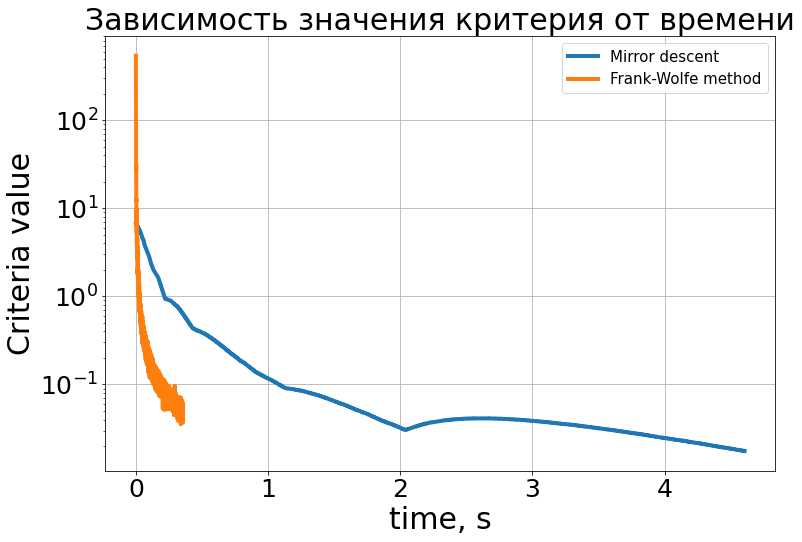

In [11]:
X1 = np.array([mirror_desc[0][i] for i in range(0, 9999)])
Y1 = np.array([mirror_desc[1][i] for i in range(0, 9999)])

X2 = np.array([FW[0][i] for i in range(0, 9999)])
Y2 = np.array([FW[1][i] for i in range(0, 9999)])

plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'Mirror descent')
plt.semilogy(X2, Y2, linewidth=4, label = 'Frank-Wolfe method')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time, s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.grid()

#### Метод Франка-Вульфа с критерием gap дает значение хуже, чем метод зеркального спуска, но работает и сходится быстрее.

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [12]:
def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / (rho + 1)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [13]:
def GD_proj(A, start, lr, amount_of_iterations):
    x = start
    begin_time = time.time()
    timeprog = []
    criterion = []
    for i in range (1, amount_of_iterations):
        x = euclidean_proj_simplex(x - lr*A@x)
        timeprog.append(time.time() - begin_time)
        criterion.append(gap(A, x))
    return timeprog, criterion
gradient_descent_proj = GD_proj(A, np.ones(d)*1/100, 1/L, 10000)

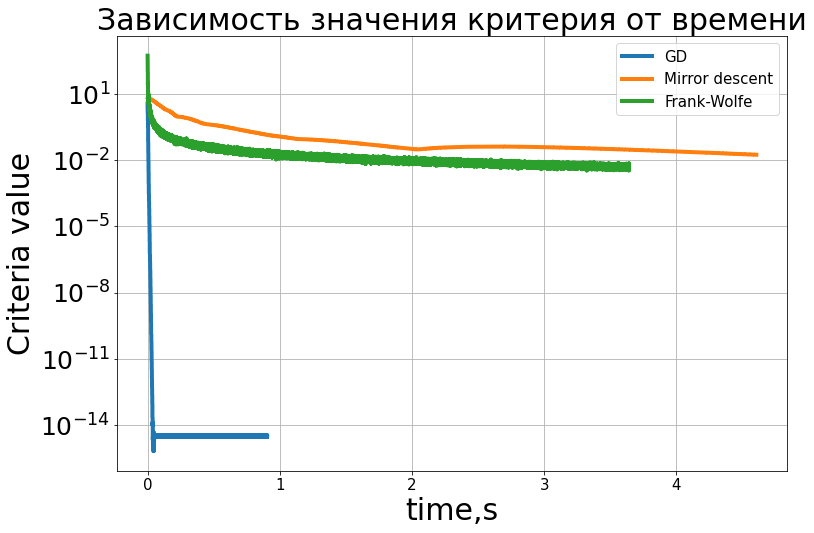

In [14]:
X1 = np.array([gradient_descent_proj[0][i] for i in range(0, 9999)])
Y1 = np.array([gradient_descent_proj[1][i] for i in range(0, 9999)])

X2 = np.array([mirror_desc[0][i] for i in range(0, 9999)])
Y2 = np.array([mirror_desc[1][i] for i in range(0, 9999)])

X3 = np.array([FW[0][i] for i in range(0, 99999)])
Y3 = np.array([FW[1][i] for i in range(0, 99999)])    
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'GD')
plt.semilogy(X2, Y2, linewidth=4, label = 'Mirror descent')
plt.semilogy(X3, Y3, linewidth=4, label = 'Frank-Wolfe')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time,s", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

Вывод: градиентный спуск сошелся лучше предыдущих методов и быстрее. Для данной задачи он оптимальный.

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [15]:
def CndG(g, u, beta, eta):
    while True:
        u0 = u
        xarg = np.nanargmin(g + beta*(u - u0))
        x = np.zeros(d)
        x[xarg] = 1
        v = (g + beta*(u - u0))@(u - x)
        if (v < eta):
            break
        alpha = min(1, ((beta*(u0 - u) - g)@(v - u))/(beta*np.linalg.norm(v - u)**2))
        u = (1 - alpha)*u + alpha*v
    return u
def CGS(A, x, y, s):
    N = int(np.ceil(2*np.sqrt(6*L/mu)))
    for i in range (1, N):
        z = (1 - 2/(i + 1))*y + 2/(i + 1)*x
        x = CndG(A@z, x, 2*L/i, 8*L*2**(-s)*1e-5/(mu*N*i))
        y = (1 - 2/(i + 1))*y + 2/(i + 1)*x
    return y

In [16]:
def Accelerated_Frank_Wolfe(A, start):
    x, y = start, start
    begin_time = time.time()
    timeprog = []
    criterion = []
    call = []
    N = int(np.ceil(2*np.sqrt(6*L/mu)))
    for s in range (1000):
        p = CGS(A, x, y, s)
        timeprog.append(time.time() - begin_time)
        criterion.append(gap(A, p))
        call.append(N*s)
    return timeprog, criterion, call

In [17]:
AFW = Accelerated_Frank_Wolfe(A, np.ones(d)/d)

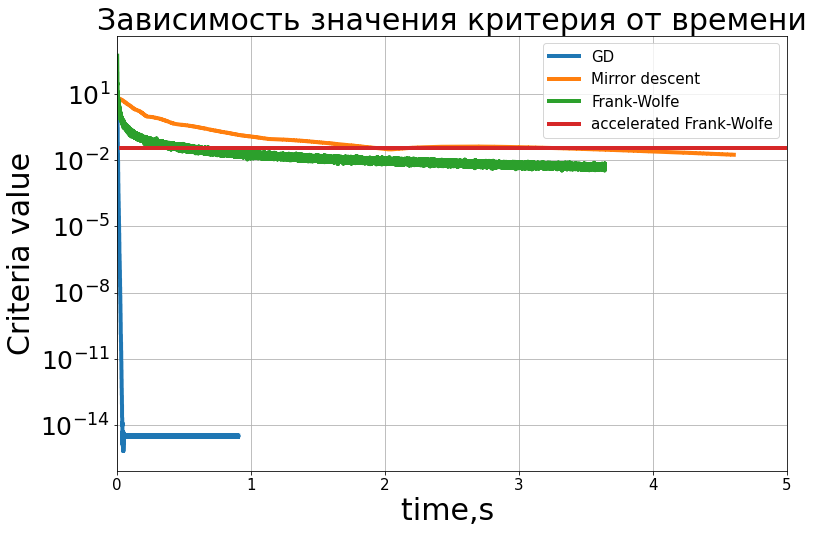

In [18]:
X1 = np.array([gradient_descent_proj[0][i] for i in range(0, 9999)])
Y1 = np.array([gradient_descent_proj[1][i] for i in range(0, 9999)])

X2 = np.array([mirror_desc[0][i] for i in range(0, 9999)])
Y2 = np.array([mirror_desc[1][i] for i in range(0, 9999)])

X3 = np.array([FW[0][i] for i in range(0, 99999)])
Y3 = np.array([FW[1][i] for i in range(0, 99999)])    

X4 = np.array([AFW[0][i] for i in range(0, 999)])
Y4 = np.array([AFW[1][i] for i in range(0, 999)])   
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'GD')
plt.semilogy(X2, Y2, linewidth=4, label = 'Mirror descent')
plt.semilogy(X3, Y3, linewidth=4, label = 'Frank-Wolfe')
plt.semilogy(X4, Y4, linewidth=4, label = 'accelerated Frank-Wolfe')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"time,s ", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.xlim(0,5)


plt.grid(True)

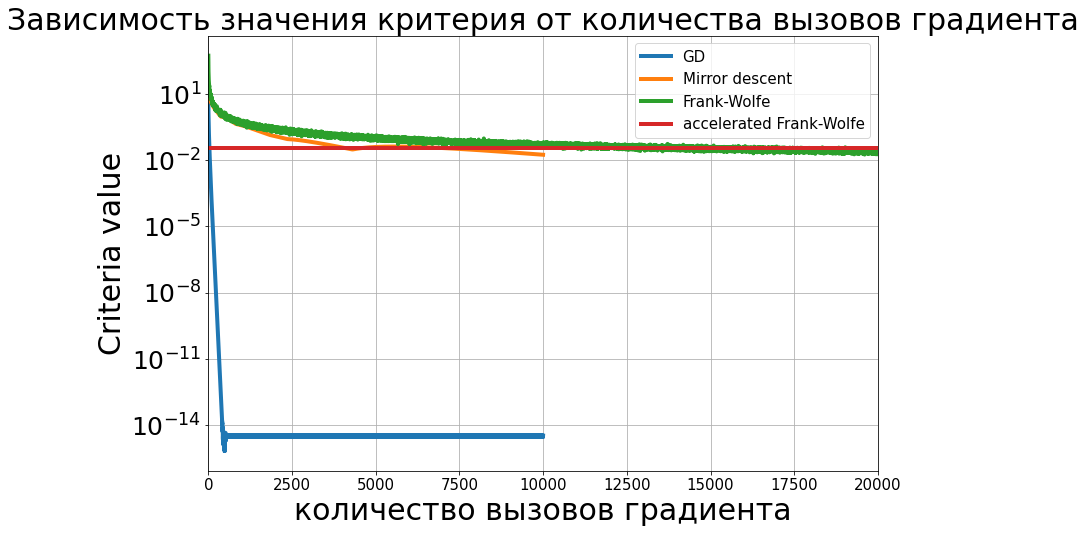

In [19]:
X1 = np.array([i for i in range(0, 9999)])
Y1 = np.array([gradient_descent_proj[1][i] for i in range(0, 9999)])

X2 = np.array([i for i in range(0, 9999)])
Y2 = np.array([mirror_desc[1][i] for i in range(0, 9999)])

X3 = np.array([i for i in range(0, 99999)])
Y3 = np.array([FW[1][i] for i in range(0, 99999)])    

X4 = np.array([AFW[2][i] for i in range(0, 999)])
Y4 = np.array([AFW[1][i] for i in range(0, 999)])   
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'GD')
plt.semilogy(X2, Y2, linewidth=4, label = 'Mirror descent')
plt.semilogy(X3, Y3, linewidth=4, label = 'Frank-Wolfe')
plt.semilogy(X4, Y4, linewidth=4, label = 'accelerated Frank-Wolfe')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"количество вызовов градиента", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от количества вызовов градиента", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.xlim(0, 20000)

plt.grid(True)

Вывод: ускоренный метод Франка-Вульфа работает долго, и сходится примерно как обычный Франк-Вульф, но достигает своей точности горадо быстрее, так же быстро как и GD с евклидовой проекицей